# ASQUIRE DATA LOADING

In [26]:
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
import IPython.display as ipd
from scipy import signal
import soundfile as sf
import pandas as pd
import numpy as np
import subprocess
import functools
import librosa
import shutil
import glob
import json
import os

from lib.asqlib import *

## DATA PATHS

In [27]:
EXP_VER = "v12"
REPORT_FOLDER = f"report_{EXP_VER}"

ASQ_MUSTER_CSV = f"{REPORT_FOLDER}/asquire_corpus_muster.csv"
ASQ_LABELS_CSV = f"{REPORT_FOLDER}/all_asq_aud_anotes.csv"

In [28]:
pd.read_csv(ASQ_MUSTER_CSV)

,index,sub_id,age,gender,height,weight,meta-data--file_path,anot--meta-data--file_path,breath--file_path,anot--breath--file_path,...,uu--file_path,anot--uu--file_path,yee--file_path,anot--yee--file_path,zz--file_path,anot--zz--file_path,sent--file_path,anot--sent--file_path,~noise~--file_path,anot--~noise~--file_path
0,0,qwer-0177a438,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,1,bugsbunny-13f848d8,-,-,-,-,-,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,...,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-
2,2,doll-808ed97a,-,-,-,-,-,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,...,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-
3,3,varun-8f78ac35,-,-,-,-,-,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,...,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-
4,4,murugeswari-d700dff3,-,-,-,-,-,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,...,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,227,harisk-6f82d610,58,m,175,88,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,...,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,-,-,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,-,-,-,-
228,228,arhaam-350fc3e6,6,m,114,30,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,-,-,-,-,-,-,-,-
229,229,ravisk-cd186836,60,m,177,83,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,-,-,-,-
230,230,srinivas-b89febe6,60,m,172,85,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,-,-,-,-


In [29]:
pd.read_csv(ASQ_LABELS_CSV)["label"].unique()

array(['oo', 'yy', 'cc', 'ss', 'aa', 'uu', 'ii', 'xx', 'ee', 'zz', 'ii-n'],
      dtype=object)

In [30]:
pd.read_csv(ASQ_LABELS_CSV).columns

Index(['app_code', 'sub_id', 'file_class', 'file_xindex', 'score',
       'file_format', 'file_name', 'file_path', 'file_match',
       'anot--file_format', 'anot--file_name', 'anot--file_path', 'age',
       'gender', 'height', 'weight', 'start', 'end', 'label', 'line_number',
       'dur'],
      dtype='object')

In [38]:
class DataFolds(DataStaticInfo):

    LABELS = ['aa', 'ee', 'uu', 'oo', 'ii', 'xx', 'cc', 'yy', 'ss',  'zz', 'ii-n']
    VOW_LABELS = ['aa', 'ee', 'uu']

    FOLD_k = "fold"
    TOTAL_k = "total"

    ASQ_SUBJECT_LABEL_STAT_FNAME = "asq_subject_label_stats"
    ASQ_SUBJECT_VOWEL_FOLDS_FNAME = "asq_subject_vowel_folds"

    N_FOLDS: int

    ASQ_ANNOTATION_DF: pd.DataFrame
    SUB_LABEL_STAT_DF: pd.DataFrame
    ASQ_VOWEL_FILT_DF: pd.DataFrame

    def __init__(self, annotation_csv: str, folds: int = 5) -> None:
        
        self.N_FOLDS = folds
        self.ASQ_ANNOTATION_DF = pd.read_csv(annotation_csv)
        self.SUB_LABEL_STAT_DF = self.sub_label_stat()
        self.ASQ_VOWEL_FILT_DF = self.sub_vowel_filt()

    
    def sub_label_stat(self, label_df: pd.DataFrame|bool=False) -> pd.DataFrame:

        if not type(label_df) == pd.DataFrame:
            label_df = self.ASQ_ANNOTATION_DF

        label_df = label_df.copy()

        sub_dicts = []
        for sid in self.get_subjects():

            
            filt = label_df[self.fkeys['SID']] == sid
            sub_df: pd.DataFrame = label_df[filt]
            
            sub_dict = {
                f"{self.fkeys['SID']}": sid,
            } | sub_df.iloc[0][[self.GENDER_k, self.AGE_k]].to_dict()

            sub_dict[self.TOTAL_k] = sub_df[self.DUR_k].sum()

            for label in self.LABELS:
                filt = sub_df[self.LABEL_k] == label
                sub_label_stats_df = sub_df[filt]

                # count = sub_label_df.shape[0]
                total_dur = np.round(sub_label_stats_df[self.DUR_k].sum(), 2)
                mean_dur = np.round(sub_label_stats_df[self.DUR_k].mean(), 2)
                std_dur = np.round(sub_label_stats_df[self.DUR_k].std(), 2)
                cov = np.round(std_dur/mean_dur, 2)
                
                sub_dict[f"{label}_count"] = sub_label_stats_df.shape[0]
                sub_dict[f"{label}_dur"] = total_dur
                sub_dict[f"{label}_mean"] = mean_dur
                sub_dict[f"{label}_std"] = std_dur
                sub_dict[f"{label}_cov"] = cov

            sub_dicts.append(sub_dict)

        sub_label_stats_df =  pd.DataFrame(sub_dicts)
        sub_label_stats_df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)


        export_path = os.path.join(REPORT_FOLDER, 
                                   f"{self.ASQ_SUBJECT_LABEL_STAT_FNAME}.csv")
        
        sub_label_stats_df.to_csv(export_path, index=False)
        
        return sub_label_stats_df
    
    MIN_VOWEL_DUR = 20.0

    def sub_vowel_filt(self, label_stat_df: pd.DataFrame|bool=False) -> pd.DataFrame:

        if not type(label_stat_df) == pd.DataFrame:
            label_stat_df = self.SUB_LABEL_STAT_DF

        label_stat_df = label_stat_df.copy()

        # duration filter
        filts = [label_stat_df[f"{l}_dur"] > self.MIN_VOWEL_DUR for l in self.VOW_LABELS]
        filt = functools.reduce(lambda p, c: p & c, filts)

        vowel_stat_df = label_stat_df[filt]

        cols = ['sub_id', self.AGE_k, self.GENDER_k]
        cols += vowel_stat_df.columns[vowel_stat_df.columns.str.contains('|'.join(self.VOW_LABELS))].tolist()
        vowel_stat_df = vowel_stat_df[cols]

        dur_cols = vowel_stat_df.columns[vowel_stat_df.columns.str.contains(self.DUR_k)].tolist()
        vowel_stat_df[self.TOTAL_k] = vowel_stat_df[dur_cols].sum(axis=1)
        vowel_stat_df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)

        genders = ['f', 'm']

        vowel_folds_dfs = [self.make_folds(self.gender_filter(vowel_stat_df, g), self.N_FOLDS) for g in genders]

        vowel_folds_df =  pd.concat(vowel_folds_dfs)

        filt_subjects = vowel_folds_df[self.fkeys['SID']].unique()

        filt = self.ASQ_ANNOTATION_DF[self.fkeys['SID']].isin(filt_subjects)
        filt &= self.ASQ_ANNOTATION_DF[self.LABEL_k].isin(self.VOW_LABELS)


        vowel_filt_df = self.ASQ_ANNOTATION_DF[filt]

        vowel_filt_df = vowel_filt_df.merge(vowel_folds_df[[self.fkeys['SID'], self.FOLD_k]], on=[self.fkeys['SID']])

        export_path = os.path.join(REPORT_FOLDER, 
                                   f"{self.ASQ_SUBJECT_VOWEL_FOLDS_FNAME}.csv")
        
        vowel_filt_df.to_csv(export_path, index=False)

        return vowel_filt_df
    
    def make_folds(self, df: pd.DataFrame, n) -> pd.DataFrame:

        df = df.copy()

        df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)

        groups = []
        group_sums = np.zeros(n)

        for _, rv in df.iterrows():
            # Find the group with the smallest sum and assign the current row to it
            min_sum_index = np.argmin(group_sums)
            groups.append((rv[self.fkeys['SID']], min_sum_index))
            group_sums[min_sum_index] += rv[self.TOTAL_k]

        # Create a new DataFrame with the group assignments
        grouped_data = pd.DataFrame(groups, columns=[self.fkeys['SID'], self.FOLD_k])

        # Merge the original DataFrame with the grouped data
        result_df = df.merge(grouped_data, on=[self.fkeys['SID']])

        return result_df


    def get_subjects(self, df: pd.DataFrame=False) -> list:
        if not type(df) == pd.DataFrame:
            df = self.ASQ_ANNOTATION_DF
        return df[self.fkeys['SID']].unique()
    
    def gender_filter(self, df, gender: str):
        filt = df[self.GENDER_k] == gender
        return df[filt]

    PAD = 0.0

    def viz_random_chunk(self) -> ipd.Audio:
        label_df = self.ASQ_VOWEL_FILT_DF

        i = np.random.randint(0, label_df.shape[0])

        rv = label_df.iloc[i]

        sid = rv[self.fkeys['SID']]
        audio_path = rv[self.fkeys['FPATH']]
        begin = rv[self.BEGIN_k]
        end = rv[self.END_k]
        label = rv[self.LABEL_k]

        sig, fs = librosa.load(audio_path, offset=begin-self.PAD, duration=(end - begin + 2*self.PAD))

        # plt.figure(figsize=(128, 12))
        self.plot_spectrogram(sig, fs, f"{label}, {sid}")
        # self.plot_sig(sig, fs, label)
        return ipd.Audio(sig, rate=fs)

    def plot_spectrogram(self, sig, fs, label):
        f, t, Sxx = signal.spectrogram(sig, fs, window='hann', nperseg=512, noverlap=256, nfft=512, detrend=False)

        plt.figure(figsize=(16, 6))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='nearest')  # Convert to dB scale
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(f"{label}")
        plt.colorbar(label='Intensity [dB]')
        plt.ylim(0, fs / 2)  # Limit the y-axis to the positive frequency range
        plt.tight_layout()
        plt.show()

    def plot_sig(self, aud, fs, label, scale=1.0, c='blue'):
        plt.title(f"{label}", fontsize=12)
        t = np.linspace(0, len(aud)/fs, len(aud))
        plt.plot(t, aud*scale, color=c)

asq_datafolds = DataFolds(annotation_csv=ASQ_LABELS_CSV)
vow_df = asq_datafolds.sub_vowel_filt(); vow_df

,app_code,sub_id,file_class,file_xindex,score,file_format,file_name,file_path,file_match,anot--file_format,...,age,gender,height,weight,start,end,label,line_number,dur,fold
0,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,2.649042,15.221481,aa,1,12.572439,0
1,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,17.365944,28.634885,aa,2,11.268941,0
2,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,30.947541,40.912986,aa,3,9.965445,0
3,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,44.372402,58.094161,aa,4,13.721759,0
4,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,60.715171,76.338447,aa,5,15.623276,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,11.487568,21.274378,aa,2,9.786810,3
901,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,23.631568,32.135351,aa,3,8.503783,3
902,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,2.262486,17.569622,ee,1,15.307136,3
903,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,19.266486,29.129514,ee,2,9.863028,3


In [32]:

for f in vow_df['fold'].unique():
    filt = vow_df['fold'] == f
    df = vow_df[filt]

    # print(f'Fold {f}', df['sub_id'].unique())
    # print('duration', df['total'].sum())
    print(f)
    # print(df['gender'].value_counts())

0
3
2
1
4


In [39]:
asq_datafolds.ASQ_VOWEL_FILT_DF

,app_code,sub_id,file_class,file_xindex,score,file_format,file_name,file_path,file_match,anot--file_format,...,age,gender,height,weight,start,end,label,line_number,dur,fold
0,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,2.649042,15.221481,aa,1,12.572439,0
1,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,17.365944,28.634885,aa,2,11.268941,0
2,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,30.947541,40.912986,aa,3,9.965445,0
3,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,44.372402,58.094161,aa,4,13.721759,0
4,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,60.715171,76.338447,aa,5,15.623276,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,11.487568,21.274378,aa,2,9.786810,3
901,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,23.631568,32.135351,aa,3,8.503783,3
902,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,2.262486,17.569622,ee,1,15.307136,3
903,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,19.266486,29.129514,ee,2,9.863028,3


/tmp/ipykernel_534184/3690996940.py:180: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='nearest')  # Convert to dB scale


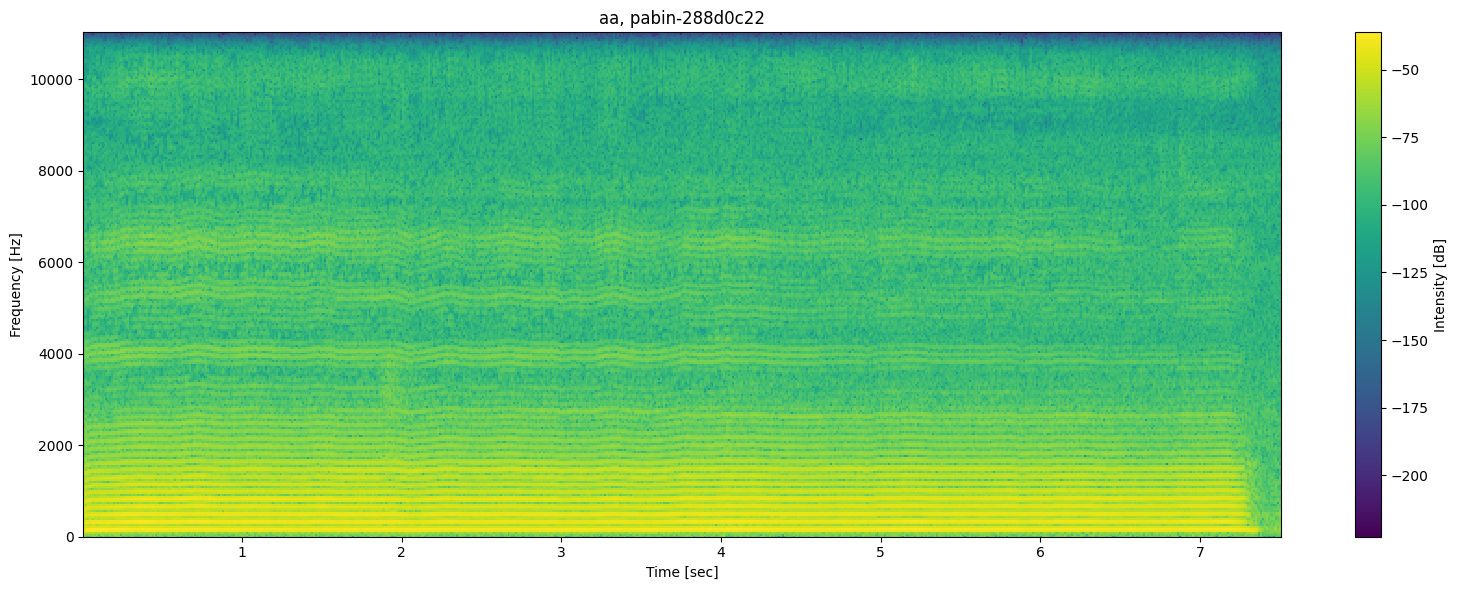

In [60]:
asq_datafolds.viz_random_chunk()

#### TESTS